<a href="https://colab.research.google.com/github/AmirGhnbr/PubMed_200k_RCT/blob/dev_branch/PubMed_200k_RCT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pubmed RTC 200k

Using Pubmed RTC 200K we are aiming for train the NN for to distinguish the abstract of each paper. 

The dataset is coming from [PubMed 200k RCT](https://arxiv.org/pdf/1710.06071.pdf) paper. 

we will use the NN architecture described in [Neural Networks for Joint Sentence Classification in Medical Paper Abstracts](https://arxiv.org/pdf/1612.05251.pdf) paper.

PubMed is a free search engine accessing primarily the MEDLINE database of references and abstracts on life sciences and biomedical topics. The United States National Library of Medicine (NLM) at the National Institutes of Health maintain the database as part of the Entrez system of information retrieval.



In [1]:
## Set up GPU
!nvidia-smi

Fri Nov 18 10:37:52 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8    12W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Donwload the dataset

### In a phenomenal act of kindness, the authors of the paper have made the data they used for their research availably publically and for free in the form of .txt files on [GitHub](https://github.com/Franck-Dernoncourt/pubmed-rct).

In [2]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [3]:
# Check what files are in the PubMed_20K dataset 
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


In [4]:
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [5]:
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

## Preprocess data

In [6]:
def get_lines(filepath):
  """
  open and return the files
  """
  with open(filepath,"r") as f:
    return f.readlines()

In [7]:
train_lines = get_lines(data_dir + "train.txt")
train_lines[:16]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [8]:
def preprocess_with_line_numbers(filepath):
  """
  Takes in filename, reads its contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence number
  the target line is.

  Args: 
  
  filename: a string of the target path
  """
  input_lines = get_lines(filepath)
  abstract_lines = ""
  abstract_samples = []

  for line in input_lines:
    if line.startswith("###") :
      abstract_id = line
      abstract_lines = ""
    elif line.isspace(): # check to see if its new line
      abstract_line_split = abstract_lines.splitlines() 

      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {}
        target_text_split = abstract_line.split("\t")
        line_data["target"] = target_text_split[0]
        line_data["text"] = target_text_split[1].lower()
        line_data["line_number"] = abstract_line_number 
        line_data["total_lines"] = len(abstract_line_split) - 1
        abstract_samples.append(line_data)

    else:
      abstract_lines += line

  return abstract_samples

In [9]:
%%time
train_samples = preprocess_with_line_numbers(data_dir+"train.txt")
val_samples = preprocess_with_line_numbers(data_dir+"dev.txt")
test_samples = preprocess_with_line_numbers(data_dir + "test.txt")
len(train_samples), len(val_samples), len(test_samples)

CPU times: user 458 ms, sys: 97.9 ms, total: 556 ms
Wall time: 558 ms


(180040, 30212, 30135)

In [10]:
train_samples[:14]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

## Lets turn ductionaries into dataframe

In [11]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(16)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [12]:
train_df["target"].value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

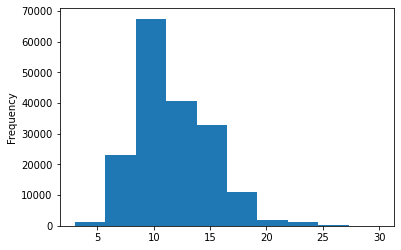

In [13]:
train_df["total_lines"].plot.hist();

looks like majority of abstracts are around 7-15 lenght

## get list of sentences

When we build our deep learning model, one of its main inputs will be a list of strings (the lines of an abstract).

In [14]:
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## make labels numerical

In [15]:
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1,1))

train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

### label encodes labels

In [16]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

train_labels_encoded, train_labels_encoded.shape

(array([3, 2, 2, ..., 4, 1, 1]), (180040,))

In [17]:
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Baseline model

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
    ("TfidfVectorizer", TfidfVectorizer()),
    ("gaussianNB", MultinomialNB())
])

model_0.fit(train_sentences, train_labels_encoded)

Pipeline(steps=[('TfidfVectorizer', TfidfVectorizer()),
                ('gaussianNB', MultinomialNB())])

In [ ]:
model_0.score(val_sentences, val_labels_encoded)

0.7218323844829869

In [ ]:
baseline_preds = model_0.predict(test_sentences)
baseline_preds

array([2, 2, 2, ..., 4, 4, 4])

For evaluate how our model performs we are using following metrics:

* Accuracy: $\frac {TP}{(TP+TN)}$

* Precision: $\frac {TP}{(TP+FP)}$

* Recall: $\frac {TP}{(TP+FN)}$

* F1-score: $\frac {2}{\frac {1}{Precision}+ \frac {1}{recall}}$

In [ ]:
# download helper function
!wget https://raw.githubusercontent.com/AmirGhnbr/Big-Food-Vision/main/helper.py

--2022-11-16 17:13:10--  https://raw.githubusercontent.com/AmirGhnbr/Big-Food-Vision/main/helper.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10568 (10K) [text/plain]
Saving to: ‘helper.py.1’

helper.py.1         100%[===================>]  10.32K  --.-KB/s    in 0s      

2022-11-16 17:13:10 (93.6 MB/s) - ‘helper.py.1’ saved [10568/10568]



In [ ]:
from helper import calculate_results
calculate_results(test_labels_encoded,
                  baseline_preds) 

{'accuracy': 71.6674962667994,
 'precision': 0.7124322482375202,
 'recall': 0.716674962667994,
 'f1': 0.6925101703856846}

## Prepare data for sequence models

In [18]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [19]:
sen_length = [len(sentence.split()) for sentence in train_sentences]
sen_length[:10]

[49, 27, 15, 14, 35, 29, 30, 55, 36, 8]

In [20]:
average_sentence_len = np.mean(sen_length)
average_sentence_len

26.338269273494777

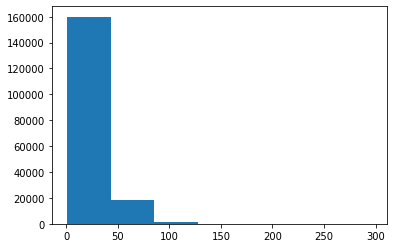

In [21]:
import matplotlib.pyplot as plt
plt.hist(sen_length,bins =7);

In [22]:
output_sec_len = int(np.percentile(sen_length,95))
output_sec_len

55

95 % of data's length are less than 55

## Create Text vectorizer

In [23]:
max_tokens = 68000 ## according to paper

In [24]:
from tensorflow.keras.layers import TextVectorization

text_vectorizer = TextVectorization(max_tokens = max_tokens,
                                    output_sequence_length =output_sec_len)
text_vectorizer

In [25]:
text_vectorizer.adapt(train_sentences)

In [26]:
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text:\n{text_vectorizer([target_sentence])}")

Text:
one fatal toxic effect , neutropenic sepsis , occurred in the primary-chemotherapy group .

Length of text: 14

Vectorized text:
[[   88  4118  3584    70 36546  1762   344     5     2 25020    13     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [27]:
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocabulary: {len(rct_20k_text_vocab)}"), 
print(f"Most common words in the vocabulary: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocabulary: {rct_20k_text_vocab[-5:]}")

Number of words in vocabulary: 64841
Most common words in the vocabulary: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocabulary: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


## Create custom  text Embedding

Word embeddings give us a way to use an efficient, dense representation in which similar words have a similar encoding. Importantly, you do not have to specify this encoding by hand. An embedding is a dense vector of floating point values (the length of the vector is a parameter you specify). Instead of specifying the values for the embedding manually, they are trainable parameters (weights learned by the model during training, in the same way a model learns weights for a dense layer). It is common to see word embeddings that are 8-dimensional (for small datasets), up to 1024-dimensions when working with large datasets. A higher dimensional embedding can capture fine-grained relationships between words, but takes more data to learn. [Tensorflow docs](https://www.tensorflow.org/text/guide/word_embeddings)

For better understanding of the werd emmbeding you can head over to [tensorflow emmbedding projector](http://projector.tensorflow.org/)

In [28]:
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab),
                               output_dim = 256,
                               mask_zero= True,
                               name= "embedding")

In [29]:
print(f"Sentence before vectorization:\n{target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n{vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n{embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
one fatal toxic effect , neutropenic sepsis , occurred in the primary-chemotherapy group .

Sentence after vectorization (before embedding):
[[   88  4118  3584    70 36546  1762   344     5     2 25020    13     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Sentence after embedding:
[[[ 0.02031157 -0.02695917 -0.0057125  ... -0.00101729  0.04955498
   -0.00998531]
  [ 0.03794629 -0.00504376  0.02577169 ... -0.02376146  0.00146942
   -0.04134069]
  [ 0.03825518 -0.0258104  -0.02082168 ...  0.00590938 -0.01884267
    0.02868338]
  ...
  [-0.02700957 -0.03986873  0.04936615 ... -0.02124349  0.02024276
   -0.01479224]
  [-0.02700957 -0.03986873  0.04936615 ... -0.02124349  0.02024276
   -0.01479224]
  [-0.02700957 -0.03986873  0.04936615

## Create datasets

The `tf.data` API enables you to build complex input pipelines from simple, reusable pieces.

(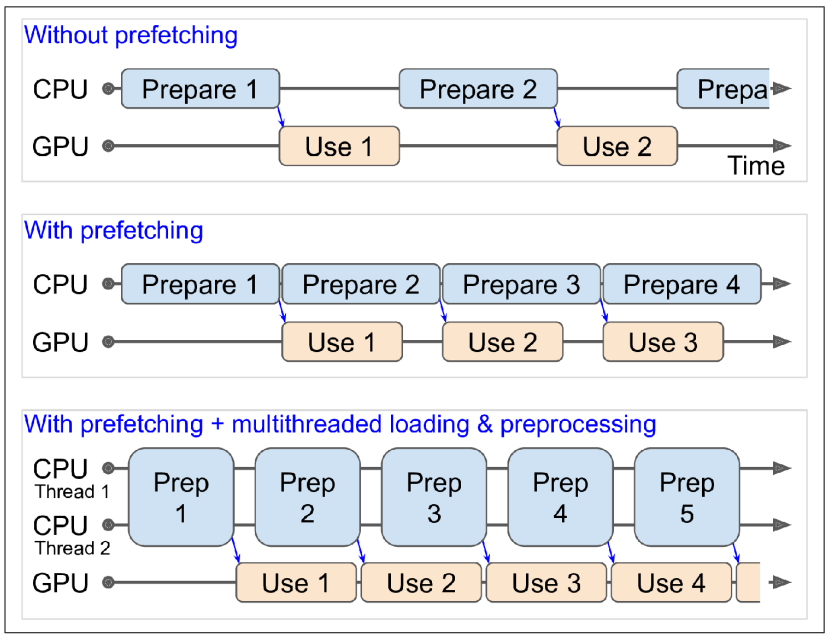)

In [30]:
train_dataset= tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [31]:
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [32]:
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vector = text_vectorizer(inputs)
token_embeding = token_embed(text_vector)
x = layers.Conv1D(64, 5, padding="same", activation="relu")(token_embeding)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.models.Model(inputs, outputs)
model_1.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 55, 256)           16599296  
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            81984     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 325   

## Model 1
Use Adam optimizer instead of sgd

We introduce [Adam](https://arxiv.org/abs/1412.6980), an algorithm for first-order gradient-based optimization of
stochastic objective functions, based on adaptive estimates of lower order moments.

In [ ]:
model_1.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model_1_hist= model_1.fit(train_dataset,
                          steps_per_epoch= int(0.1*len(train_dataset)),
                          epochs=5, 
                          validation_data= val_dataset,
                          validation_steps = int(0.1*len(val_dataset))
                          )

Epoch 1/5
562/562 [==============================] - 10s 17ms/step - loss: 0.8757 - accuracy: 0.6571 - val_loss: 0.6720 - val_accuracy: 0.7473
Epoch 2/5
562/562 [==============================] - 8s 15ms/step - loss: 0.6464 - accuracy: 0.7624 - val_loss: 0.6301 - val_accuracy: 0.7719
Epoch 3/5
562/562 [==============================] - 8s 15ms/step - loss: 0.6083 - accuracy: 0.7786 - val_loss: 0.5876 - val_accuracy: 0.7902
Epoch 4/5
562/562 [==============================] - 8s 15ms/step - loss: 0.5808 - accuracy: 0.7919 - val_loss: 0.5729 - val_accuracy: 0.7922
Epoch 5/5
562/562 [==============================] - 8s 15ms/step - loss: 0.5848 - accuracy: 0.7931 - val_loss: 0.5561 - val_accuracy: 0.7999


In [ ]:
model_1.evaluate(test_dataset)

942/942 [==============================] - 4s 4ms/step - loss: 0.5670 - accuracy: 0.7967


[0.5670065879821777, 0.7967147827148438]

In [ ]:
model_1_prob_preds = model_1.predict(test_dataset)
model_1_prob_preds

942/942 [==============================] - 3s 3ms/step


array([[2.1729074e-01, 9.5805205e-02, 5.0927418e-01, 1.0881178e-01,
        6.8818107e-02],
       [9.8127080e-03, 3.5621454e-03, 9.4815695e-01, 7.4015055e-03,
        3.1066684e-02],
       [4.6380094e-04, 1.4711133e-03, 9.6421909e-01, 2.8822498e-04,
        3.3557620e-02],
       ...,
       [4.7838199e-03, 3.2394905e-02, 1.8653898e-02, 2.0286900e-03,
        9.4213873e-01],
       [5.1525095e-03, 2.8583944e-02, 5.8615938e-02, 2.4963475e-03,
        9.0515125e-01],
       [9.7994432e-03, 6.1315024e-01, 3.5109494e-02, 9.5901610e-03,
        3.3235070e-01]], dtype=float32)

In [ ]:
model_1_preds = np.argmax(model_1_prob_preds, axis=1)
model_1_preds

array([2, 2, 2, ..., 4, 4, 1])

In [ ]:
model_1_result = calculate_results(test_labels_encoded,
                                   model_1_preds)
model_1_result

{'accuracy': 79.67147834743653,
 'precision': 0.796461045017881,
 'recall': 0.7967147834743653,
 'f1': 0.7937664413544584}

## Model 2: Feature Extractor model with pretrained token embeddings

In [ ]:
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name = "universal_sentence_encoder")
tf_hub_embedding_layer

In [ ]:
random_training_sentence = random.choice(train_sentences)
use_embedded_sentence = tf_hub_embedding_layer([random_training_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence[0][:30]} (truncated output)...\n")
print(f"Length of sentence embedding:\n{len(use_embedded_sentence[0])}")

Sentence after embedding:
[-0.04465074 -0.0013063  -0.01611208 -0.03101896 -0.07102615  0.04658877
 -0.02114804 -0.06587837  0.00854012  0.03883935  0.08748774 -0.06487766
  0.07369249 -0.04348835  0.04278491  0.02593801 -0.08786374 -0.01440435
 -0.02327903 -0.02229915 -0.02592461  0.05515205 -0.06423591 -0.06752401
  0.05916411  0.03858594  0.02123257 -0.00943808 -0.02679524  0.03992185] (truncated output)...

Length of sentence embedding:
512


In [ ]:
inputs = layers.Input(shape=[], dtype = tf.string)
embedding_layer = tf_hub_embedding_layer(inputs)
x = layers.Dense(128, activation="relu")(embedding_layer)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model_2 = tf.keras.models.Model(inputs, outputs)
model_2.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_9 (Dense)             (None, 128)               65664     
                                                                 
 dense_10 (Dense)            (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
model_2.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
                optimizer= tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model_2_hist = model_2.fit(train_dataset,
                           steps_per_epoch= int(0.1*len(train_dataset)),
                           epochs=5, 
                           validation_data= val_dataset,
                           validation_steps = int(0.1*len(val_dataset)))

Epoch 1/5
562/562 [==============================] - 47s 16ms/step - loss: 0.9160 - accuracy: 0.6515 - val_loss: 0.7936 - val_accuracy: 0.6922
Epoch 2/5
562/562 [==============================] - 9s 16ms/step - loss: 0.7673 - accuracy: 0.7021 - val_loss: 0.7534 - val_accuracy: 0.7041
Epoch 3/5
562/562 [==============================] - 9s 16ms/step - loss: 0.7520 - accuracy: 0.7113 - val_loss: 0.7384 - val_accuracy: 0.7101
Epoch 4/5
562/562 [==============================] - 10s 17ms/step - loss: 0.7172 - accuracy: 0.7260 - val_loss: 0.7094 - val_accuracy: 0.7274
Epoch 5/5
562/562 [==============================] - 9s 16ms/step - loss: 0.7248 - accuracy: 0.7230 - val_loss: 0.6884 - val_accuracy: 0.7364


In [ ]:
model_2.evaluate(test_dataset)

942/942 [==============================] - 13s 13ms/step - loss: 0.7135 - accuracy: 0.7283


[0.7135071158409119, 0.7283225655555725]

In [ ]:
model_2_pred_prob = model_2.predict(test_dataset)
model_2_pred_prob

942/942 [==============================] - 12s 12ms/step


array([[3.3951098e-01, 1.2081897e-01, 1.9504791e-01, 2.8749445e-01,
        5.7127707e-02],
       [3.5188255e-01, 2.9167302e-02, 2.3227689e-01, 3.5634395e-01,
        3.0329295e-02],
       [6.3491805e-04, 3.1528154e-03, 9.2643964e-01, 7.7189342e-04,
        6.9000676e-02],
       ...,
       [3.6502370e-04, 1.8154411e-02, 1.0308941e-02, 5.8277659e-05,
        9.7111332e-01],
       [7.1463604e-03, 4.9631778e-02, 4.8664387e-02, 1.2457591e-03,
        8.9331174e-01],
       [1.4922470e-02, 3.3691004e-01, 3.5053706e-01, 9.3291728e-03,
        2.8830120e-01]], dtype=float32)

In [ ]:
model_2_preds = np.argmax(model_2_pred_prob, axis=1)
model_2_preds

array([0, 3, 2, ..., 4, 4, 2])

In [ ]:
model_2_results = calculate_results(test_labels_encoded,
                                    model_2_preds)
model_2_results

{'accuracy': 72.83225485316078,
 'precision': 0.7244803690153419,
 'recall': 0.7283225485316077,
 'f1': 0.7230270174197654}

## Model 3 : Feature Extractor Using Selu Activation Lecun initializer

### Based on [Selu paper](https://arxiv.org/pdf/1706.02515) & [lecun Initializer](https://arxiv.org/pdf/1803.01719.pdf)


* Selu activation introduced in Self-Normalizing Neural Networks paper. 

In [ ]:
import tensorflow_hub as hub
tf_hub_embedding_layer_2 = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=True,
                                        name = "universal_sentence_encoder")
tf_hub_embedding_layer_2

In [ ]:
inputs = layers.Input(shape=[], dtype = tf.string)
embedding_layer = tf_hub_embedding_layer_2(inputs)
x = layers.Dense(128, activation="selu",kernel_initializer="lecun_normal")(embedding_layer)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model_3 = tf.keras.models.Model(inputs, outputs)

model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
model_3.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_11 (Dense)            (None, 128)               65664     
                                                                 
 dense_12 (Dense)            (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 256,864,133
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_3_history = model_3.fit(train_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)),
                              epochs=5,
                              validation_data=val_dataset,
                              validation_steps=int(0.1 * len(val_dataset)))

Epoch 1/5
562/562 [==============================] - 95s 157ms/step - loss: 0.7264 - accuracy: 0.7189 - val_loss: 0.5519 - val_accuracy: 0.7859
Epoch 2/5
562/562 [==============================] - 90s 160ms/step - loss: 0.5577 - accuracy: 0.7925 - val_loss: 0.5153 - val_accuracy: 0.8025
Epoch 3/5
562/562 [==============================] - 89s 158ms/step - loss: 0.5296 - accuracy: 0.8014 - val_loss: 0.5016 - val_accuracy: 0.8072
Epoch 4/5
562/562 [==============================] - 89s 159ms/step - loss: 0.5034 - accuracy: 0.8159 - val_loss: 0.4757 - val_accuracy: 0.8182
Epoch 5/5
562/562 [==============================] - 88s 156ms/step - loss: 0.5063 - accuracy: 0.8152 - val_loss: 0.4818 - val_accuracy: 0.8208


In [ ]:
model_3.evaluate(test_dataset)

942/942 [==============================] - 13s 14ms/step - loss: 0.5126 - accuracy: 0.8107


[0.5126178860664368, 0.8106852769851685]

In [ ]:
model_3_pred_probs = model_3.predict(test_dataset)
model_3_pred_probs

942/942 [==============================] - 12s 12ms/step


array([[4.9997824e-01, 9.0170413e-02, 3.0713834e-02, 3.6813113e-01,
        1.1006381e-02],
       [1.3547944e-02, 1.8904536e-03, 9.4189423e-01, 1.3863994e-02,
        2.8803356e-02],
       [1.7248399e-03, 3.4525369e-03, 9.6350944e-01, 1.1774963e-03,
        3.0135574e-02],
       ...,
       [8.2074612e-04, 2.2105807e-02, 2.8342016e-03, 2.4658500e-04,
        9.7399265e-01],
       [1.7154269e-03, 3.0678254e-02, 9.9265100e-03, 3.9178049e-04,
        9.5728803e-01],
       [8.6337039e-03, 9.0024054e-01, 1.3246201e-02, 2.5813978e-03,
        7.5298294e-02]], dtype=float32)

In [ ]:
model_3_preds = np.argmax(model_3_pred_probs, axis=1)
model_3_preds

array([0, 2, 2, ..., 4, 4, 1])

In [ ]:
model_3_results = calculate_results(test_labels_encoded,
                                    model_3_preds)
model_3_results

{'accuracy': 81.06852497096399,
 'precision': 0.8210314810281744,
 'recall': 0.81068524970964,
 'f1': 0.8129726295145623}

## Model 4 : Conv1D with char embedding

In [ ]:
def split_chars(text):
  return " ".join(list(text))

In [ ]:
split_chars(random_training_sentence)

's c o p o l a m i n e   r a p i d l y   r e d u c e s   s y m p t o m s   i n   b o t h   t r e a t m e n t   h i s t o r y   g r o u p s   ,   a n d   d e m o n s t r a t e s   s u s t a i n e d   i m p r o v e m e n t   e v e n   i n   t r e a t m e n t   r e s i s t a n t   p a t i e n t s   .'

In [ ]:
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
print(train_chars[0])

t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .


In [ ]:
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

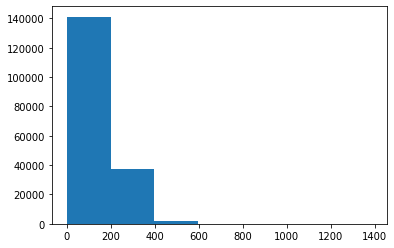

In [ ]:
# Check the distribution of our sequences at character-level
import matplotlib.pyplot as plt
plt.hist(char_lens, bins=7);

In [ ]:
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [ ]:
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
NUM_CHAR_TOKENS = len(alphabet) + 2 # num characters in alphabet + space + OOV token
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,  
                                    output_sequence_length=output_seq_char_len,
                                    standardize="lower_and_strip_punctuation",
                                    name="char_vectorizer")

# Adapt character vectorizer to training characters
char_vectorizer.adapt(train_chars)

In [ ]:
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [ ]:
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n{random_train_chars}")
print(f"\nLength of chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n{vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
e v e n t - f r e e   s u r v i v a l   d i d   n o t   d i f f e r   b e t w e e n   t h e   l a p a t i n i b   a n d   t r a s t u z u m a b   g r o u p s   (   h r   @   ,   @   %   c i   @ - @   ,   p   =   @   )   ,   n o r   b e t w e e n   t h e   c o m b i n a t i o n   a n d   t r a s t u z u m a b   g r o u p s   (   @   ,   @ - @   ,   p   =   @   )   .

Length of chars: 143

Vectorized chars:
[[ 2 21  2  6  3 17  8  2  2  9 16  8 21  4 21  5 12 10  4 10  6  7  3 10
   4 17 17  2  8 22  2  3 20  2  2  6  3 13  2 12  5 14  5  3  4  6  4 22
   5  6 10  3  8  5  9  3 16 25 16 15  5 22 18  8  7 16 14  9 13  8 11  4
  14  6  7  8 22  2  3 20  2  2  6  3 13  2 11  7 15 22  4  6  5  3  4  7
   6  5  6 10  3  8  5  9  3 16 25 16 15  5 22 18  8  7 16 14  9 14  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  

In [ ]:
char_embed = layers.Embedding(input_dim=NUM_CHAR_TOKENS, # number of different characters
                              output_dim=25, # embedding dimension of each character (same as Figure 1 in https://arxiv.org/pdf/1612.05251.pdf)
                              mask_zero=False, # don't use masks (this messes up model_5 if set to True)
                              name="char_embed")

# Test out character embedding layer
print(f"Charified text (before vectorization and embedding):\n{random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embedding):\n{char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text (before vectorization and embedding):
e v e n t - f r e e   s u r v i v a l   d i d   n o t   d i f f e r   b e t w e e n   t h e   l a p a t i n i b   a n d   t r a s t u z u m a b   g r o u p s   (   h r   @   ,   @   %   c i   @ - @   ,   p   =   @   )   ,   n o r   b e t w e e n   t h e   c o m b i n a t i o n   a n d   t r a s t u z u m a b   g r o u p s   (   @   ,   @ - @   ,   p   =   @   )   .

Embedded chars (after vectorization and embedding):
[[[ 0.03168086  0.04412064 -0.01770942 ... -0.01960422 -0.01185368
    0.02454922]
  [ 0.01491645  0.03797586  0.00212475 ...  0.04823579 -0.04180685
    0.01369921]
  [ 0.03168086  0.04412064 -0.01770942 ... -0.01960422 -0.01185368
    0.02454922]
  ...
  [ 0.0202808  -0.04922182  0.04266585 ...  0.00462861 -0.00930501
   -0.04932548]
  [ 0.0202808  -0.04922182  0.04266585 ...  0.00462861 -0.00930501
   -0.04932548]
  [ 0.0202808  -0.04922182  0.04266585 ...  0.00462861 -0.00930501
   -0.04932548]]]

Character embedding

### Nadam optimizer beats the plain old adam ([Nadam: INCORPORATING NESTEROV MOMENTUM INTO ADAM](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwjq2sOynZr7AhVsxQIHHWJaAu4QFnoECBMQAQ&url=https%3A%2F%2Fopenreview.net%2Fpdf%2FOM0jvwB8jIp57ZJjtNEZ.pdf&usg=AOvVaw0iYSzFfzEXwraAE8RXxVQS))

In [ ]:
inputs = layers.Input(shape=(1,), dtype="string")
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="selu",kernel_initializer="lecun_normal")(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_4 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="model_4_conv1D_char_embedding")

# Compile the model
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Nadam(),
                metrics=["accuracy"])

In [ ]:
model_4.summary()

Model: "model_4_conv1D_char_embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 290, 25)           1750      
                                                                 
 conv1d_2 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_13 (Dense)            (None, 5

In [ ]:
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
model_4_history = model_4.fit(train_char_dataset,
                              # steps_per_epoch=int(0.2*len(train_char_dataset)),
                              epochs=10,
                              validation_data=val_char_dataset)
                              # validation_steps=int(0.2*len(val_char_dataset)))

Epoch 1/10
5627/5627 [==============================] - 42s 7ms/step - loss: 0.8949 - accuracy: 0.6509 - val_loss: 0.7745 - val_accuracy: 0.7036
Epoch 2/10
5627/5627 [==============================] - 41s 7ms/step - loss: 0.7487 - accuracy: 0.7157 - val_loss: 0.7224 - val_accuracy: 0.7278
Epoch 3/10
5627/5627 [==============================] - 41s 7ms/step - loss: 0.7070 - accuracy: 0.7336 - val_loss: 0.7024 - val_accuracy: 0.7363
Epoch 4/10
5627/5627 [==============================] - 40s 7ms/step - loss: 0.6845 - accuracy: 0.7417 - val_loss: 0.6892 - val_accuracy: 0.7427
Epoch 5/10
5627/5627 [==============================] - 41s 7ms/step - loss: 0.6705 - accuracy: 0.7474 - val_loss: 0.6801 - val_accuracy: 0.7452
Epoch 6/10
5627/5627 [==============================] - 41s 7ms/step - loss: 0.6601 - accuracy: 0.7518 - val_loss: 0.6740 - val_accuracy: 0.7466
Epoch 7/10
5627/5627 [==============================] - 42s 7ms/step - loss: 0.6525 - accuracy: 0.7549 - val_loss: 0.6687 - val_ac

In [ ]:
model_4.evaluate(test_char_dataset)

942/942 [==============================] - 4s 4ms/step - loss: 0.6731 - accuracy: 0.7485


[0.6730612516403198, 0.7485315799713135]

In [ ]:
model_4_pred_probs = model_4.predict(test_char_dataset)
model_4_pred_probs

942/942 [==============================] - 3s 3ms/step


array([[3.8194650e-01, 1.4292203e-01, 1.6591166e-01, 2.1661234e-01,
        9.2607476e-02],
       [2.7471114e-02, 5.5844374e-02, 7.5959480e-01, 3.4707569e-02,
        1.2238214e-01],
       [6.1657556e-05, 1.7539829e-04, 8.9896554e-01, 9.2904294e-05,
        1.0070452e-01],
       ...,
       [2.5666368e-05, 6.2109684e-03, 8.3390734e-04, 1.2418938e-05,
        9.9291706e-01],
       [2.7228731e-03, 2.8870091e-02, 1.0604754e-02, 6.4074836e-04,
        9.5716155e-01],
       [3.2653864e-03, 8.2926202e-01, 2.4141991e-03, 1.3462452e-03,
        1.6371214e-01]], dtype=float32)

In [ ]:
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(30135,), dtype=int64, numpy=array([0, 2, 2, ..., 4, 4, 1])>

In [ ]:
model_4_results = calculate_results(y_true=test_labels_encoded,
                                        y_pred=model_4_preds)
model_4_results

{'accuracy': 81.06852497096399,
 'precision': 0.8210314810281744,
 'recall': 0.81068524970964,
 'f1': 0.8129726295145623}

## Model 5 lstm 

Learning to store information over extended time intervals via recurrent backpropagation takes a very long time , mostly due to insufficient, decaying error back flow. we address it by introducing a novel, efficient, gradient-based method called "Long Short-Term Memory.".[Hochreiter, S., & Schmidhuber, J"urgen. (1997). Long short-term memory. Neural Computation, 9(8), 1735–1780.](http://www.bioinf.jku.at/publications/older/2604.pdf)

In [ ]:
# LSTM MODEL
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vector = text_vectorizer(inputs)
token_embeding = token_embed(text_vector)
x = layers.LSTM(128,activation="selu",kernel_initializer="lecun_normal", return_sequences=True)(token_embeding)
x = layers.Dropout(0.3)(x)
x = layers.LSTM(128,activation="selu",kernel_initializer="lecun_normal")(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_5 = tf.keras.models.Model(inputs, outputs,name="model_5_LSTM")
model_5.summary()


Model: "model_5_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 55)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 55, 256)           16599296  
                                                                 
 lstm_6 (LSTM)               (None, 55, 128)           197120    
                                                                 
 lstm_7 (LSTM)               (None, 128)               131584    
                                                                 
 dense_14 (Dense)            (None, 5)                 645       
                                                      

In [ ]:
# Lets compile the model
model_5.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Nadam(),
                metrics="accuracy")

In [ ]:
model_5.fit(train_dataset,
            steps_per_epoch= int(0.05*len(train_dataset)),
            epochs=5, 
            validation_data= val_dataset,
            validation_steps = int(0.05*len(val_dataset)))

Epoch 1/5
281/281 [==============================] - 103s 350ms/step - loss: 0.8024 - accuracy: 0.7655 - val_loss: 0.5548 - val_accuracy: 0.7906
Epoch 2/5
281/281 [==============================] - 98s 350ms/step - loss: 0.4697 - accuracy: 0.8305 - val_loss: 0.5711 - val_accuracy: 0.7959
Epoch 3/5
281/281 [==============================] - 98s 350ms/step - loss: 0.4612 - accuracy: 0.8367 - val_loss: 0.5644 - val_accuracy: 0.7926
Epoch 4/5
281/281 [==============================] - 97s 347ms/step - loss: 0.4383 - accuracy: 0.8405 - val_loss: 0.5464 - val_accuracy: 0.7992
Epoch 5/5
281/281 [==============================] - 98s 348ms/step - loss: 0.4188 - accuracy: 0.8492 - val_loss: 0.5452 - val_accuracy: 0.8005


In [ ]:
model_5.evaluate(test_dataset)

942/942 [==============================] - 31s 33ms/step - loss: 1.2866 - accuracy: 0.7950


[1.2866082191467285, 0.7950224280357361]

In [ ]:
model_5_pred_probs = model_5.predict(test_dataset)
model_5_pred_probs

942/942 [==============================] - 28s 29ms/step


array([[3.5845998e-01, 5.4653313e-02, 3.2811540e-01, 2.0175202e-01,
        5.7019267e-02],
       [1.8089514e-02, 4.4229599e-03, 9.2386937e-01, 5.1650717e-03,
        4.8453107e-02],
       [1.1506241e-03, 1.7600748e-03, 9.6906000e-01, 7.7768380e-04,
        2.7251640e-02],
       ...,
       [8.5749198e-04, 1.7479014e-02, 7.0002140e-03, 5.3919893e-04,
        9.7412407e-01],
       [2.4690605e-03, 2.8956553e-02, 2.3433905e-02, 1.7429276e-03,
        9.4339752e-01],
       [6.8038586e-03, 7.8196782e-01, 8.4313862e-03, 4.2147082e-03,
        1.9858217e-01]], dtype=float32)

In [ ]:
model_5_preds = np.argmax(model_5_pred_probs, axis=1)
model_5_preds

array([0, 2, 2, ..., 4, 4, 1])

In [ ]:
model_5_results = calculate_results(test_labels_encoded,
                                    model_5_preds)
model_5_results

{'accuracy': 79.50223992035839,
 'precision': 0.7944952878322034,
 'recall': 0.7950223992035839,
 'f1': 0.7945282102459651}

## Model 6 biderectional lstm 

In the first part of this paper, a regular recurrent
neural network (RNN) is extended to a bidirectional recurrent
neural network (BRNN). The BRNN can be trained without
the limitation of using input information just up to a preset
future frame. This is accomplished by training it simultaneously
in positive and negative time direction. Structure and training
procedure of the proposed network are explained. [Mike Schuster & Kuldip K. Paliwal(1997), Bidirectional Recurrent Neural Networks](https://deeplearning.cs.cmu.edu/F20/document/readings/Bidirectional%20Recurrent%20Neural%20Networks.pdf)

In [33]:
## Bidirectional LSTM model
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vector = text_vectorizer(inputs)
token_embeding = token_embed(text_vector)
x = layers.Bidirectional(layers.LSTM(128,activation="selu",kernel_initializer="lecun_normal", return_sequences=True))(token_embeding)
x = layers.Dropout(0.3)(x)
x = layers.Bidirectional(layers.LSTM(128,activation="selu",kernel_initializer="lecun_normal"))(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_6 = tf.keras.models.Model(inputs, outputs,name="model_6_Bidirectional_LSTM")
model_6.summary()


Model: "model_6_Bidirectional_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 55, 256)           16599296  
                                                                 
 bidirectional (Bidirectiona  (None, 55, 256)          394240    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 55, 256)           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 256

In [35]:
model_6.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Nadam(),
                metrics="accuracy")

In [37]:
model_6.fit(train_dataset,
            steps_per_epoch= int(0.05*len(train_dataset)),
            epochs=5, 
            validation_data= val_dataset,
            validation_steps = int(0.05*len(val_dataset)))

Epoch 1/5
281/281 [==============================] - 202s 676ms/step - loss: 1.0082 - accuracy: 0.6505 - val_loss: 0.6900 - val_accuracy: 0.7274
Epoch 2/5
281/281 [==============================] - 169s 602ms/step - loss: 0.6478 - accuracy: 0.7591 - val_loss: 0.6393 - val_accuracy: 0.7540
Epoch 3/5
281/281 [==============================] - 169s 603ms/step - loss: 0.6245 - accuracy: 0.7726 - val_loss: 0.6279 - val_accuracy: 0.7593
Epoch 4/5
281/281 [==============================] - 169s 599ms/step - loss: 0.6068 - accuracy: 0.7734 - val_loss: 0.6010 - val_accuracy: 0.7686
Epoch 5/5
281/281 [==============================] - 168s 598ms/step - loss: 0.5841 - accuracy: 0.7845 - val_loss: 0.5772 - val_accuracy: 0.7846


In [39]:
model_6.evaluate(test_dataset)

942/942 [==============================] - 52s 55ms/step - loss: 0.5747 - accuracy: 0.7834


[0.5747030377388, 0.7834411859512329]

In [40]:
model_6_pred_probs = model_6.predict(test_dataset)
model_6_pred_probs

942/942 [==============================] - 54s 56ms/step


array([[3.5057217e-01, 3.1625699e-02, 6.1447229e-02, 5.5113280e-01,
        5.2220528e-03],
       [6.5082279e-03, 3.0001269e-03, 9.5231426e-01, 2.7029521e-03,
        3.5474464e-02],
       [1.9871143e-03, 1.3318564e-03, 9.7095764e-01, 8.0239412e-04,
        2.4921034e-02],
       ...,
       [3.7872656e-03, 4.4518765e-02, 1.6381996e-02, 6.2631967e-04,
        9.3468559e-01],
       [7.7508967e-03, 5.3467058e-02, 1.7643876e-02, 2.1121064e-03,
        9.1902608e-01],
       [8.4665500e-02, 5.4720545e-01, 8.4323704e-02, 3.7656143e-02,
        2.4614918e-01]], dtype=float32)

In [41]:
model_6_preds = np.argmax(model_6_pred_probs, axis=1)
model_6_preds

array([3, 2, 2, ..., 4, 4, 1])

In [42]:
model_6_results = calculate_results(test_labels_encoded,
                                    model_6_preds)
model_6_results

NameError: ignored

## Model 7 :Transfer Learning with pretrained token embeddings + character embeddings + positional embeddings

In [ ]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [ ]:
train_df["line_number"].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

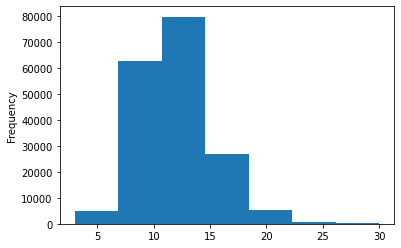

In [ ]:
train_df["total_lines"].plot.hist(bins=7);

In [ ]:
np.percentile(train_df["total_lines"],98)

20.0

In [ ]:
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)

In [ ]:
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)

train_total_lines_one_hot[:15]

<tf.Tensor: shape=(15, 20), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
     

In [ ]:
# 1. Token inputs
token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="selu",kernel_initializer="lecun_normal")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Char inputs
char_inputs = layers.Input(shape=(1,), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(32,activation="selu",kernel_initializer="lecun_normal"))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Line numbers inputs
line_number_inputs = layers.Input(shape=(15,), dtype=tf.int32, name="line_number_input")
x = layers.Dense(32, activation="selu",kernel_initializer="lecun_normal")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)

# 4. Total lines inputs
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.int32, name="total_lines_input")
y = layers.Dense(32, activation="selu",kernel_initializer="lecun_normal")(total_lines_inputs)
total_line_model = tf.keras.Model(inputs=total_lines_inputs,
                                  outputs=y)

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name="token_char_hybrid_embedding")([token_model.output, 
                                                                              char_model.output])
z = layers.Dense(256, activation="selu",kernel_initializer="lecun_normal")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embeddings with combined token and char embeddings into a tribrid embedding
z = layers.Concatenate(name="token_char_positional_embedding")([line_number_model.output,
                                                                total_line_model.output,
                                                                z])

# 7. Create output layer
output_layer = layers.Dense(5, activation="softmax", name="output_layer")(z)

# 8. Put together model
model_7 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_line_model.input,
                                 token_model.input, 
                                 char_model.input],
                                 outputs=output_layer)

In [ ]:
model_7.summary()

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_inputs[0][0]']    

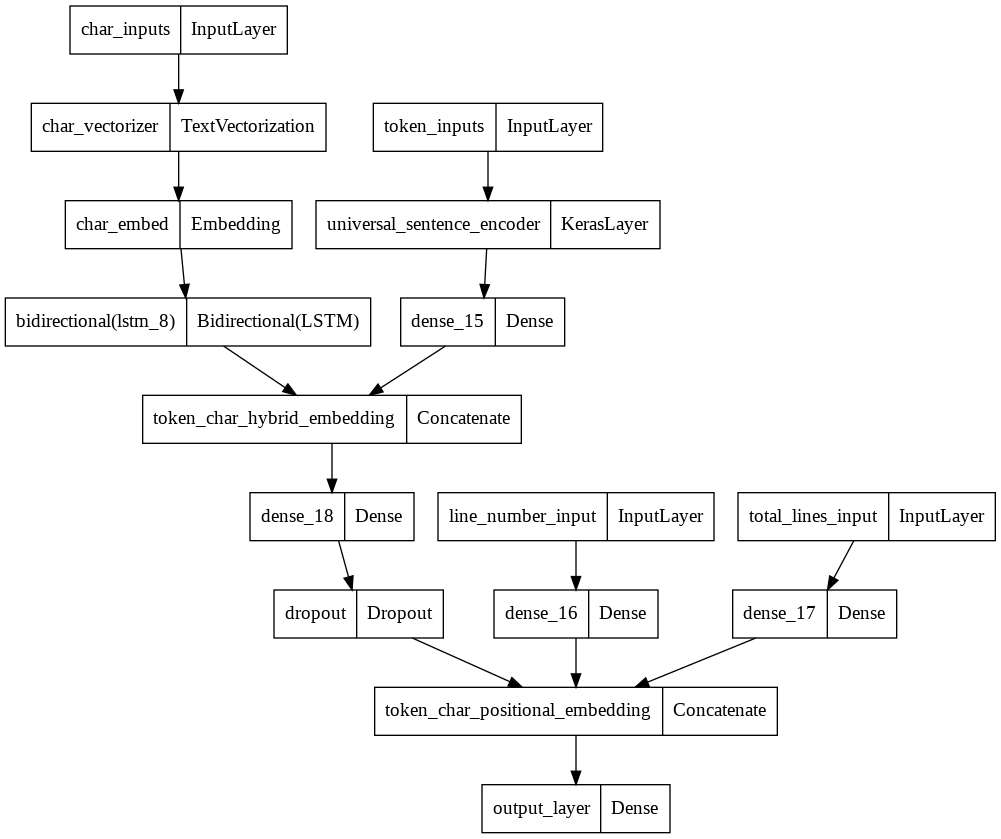

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model_7)

In [ ]:
model_7.compile(loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                optimizer = tf.keras.optimizers.Nadam(),
                metrics= ["accuracy"])

In [ ]:
# Create training and validation datasets (all four kinds of inputs)
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot, # line numbers
                                                                train_total_lines_one_hot, # total lines
                                                                train_sentences, # train tokens
                                                                train_chars)) # train chars
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # train labels
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels)) # combine data and labels
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Validation dataset
val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Check input shapes
train_pos_char_token_dataset, val_pos_char_token_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [ ]:
model_7_hist = model_7.fit(train_pos_char_token_dataset,
                           steps_per_epoch=int(0.02 * len(train_pos_char_token_dataset)),
                           epochs=42,
                           validation_data=val_pos_char_token_dataset,
                           validation_steps=int(0.02 * len(val_pos_char_token_dataset)),
                           callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
                                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=3, verbose=1)])

RuntimeError: ignored

In [ ]:
model_7.evaluate(val_pos_char_token_dataset)

In [ ]:
model_7_pred_probs = model_5.predict(val_pos_char_token_dataset, verbose=1)
model_7_pred_probs

In [ ]:
model_7_preds = np.argmax(model_7_pred_probs, axis=1)
model_7_preds

In [ ]:
model_7_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_7_preds)
model_7_results

In [ ]:
### plot the result 
results_df = pd.DataFrame({"model_1": model_1_result,
                           "model_2": model_2_results,
                           "model_3": model_3_results,
                           "model_4": model_4_results,
                           "model_7": model_7_results})
results_df_transposed = results_df.transpose()
results_df_transposed

In [ ]:
test = results_df_transposed
test["accuracy"] = results_df_transposed["accuracy"]/100
test.plot(kind="bar", figsize=(10,7)).legend(bbox_to_anchor=(1.0,1.0));

In [ ]:
test.sort_values("f1", ascending=False).plot(kind="bar",figsize=(10,7));